# Assignment 04

Due Oct 4, 11:59pm. Please submit one .ipynb file to Beachboard. 

<p style='text-align: right; '> Hansell Perez </p>
<p style='text-align: right; '> October 4, 2022 </p>

In the class, we have covered the topic of using Robust PCA to denoise the Yale Face images, with salt and pepper noise. In particular, we have defined a function to add random salt and pepper noise. In this assignment, you are asked to defined your own function to add patch noise to the images and then try to recover the original images. That is, you will create a mask with the same shape as your data tensor which will have value one for pathces of size (20, 20) position randomly in each sample. 

Please refer to [Robust Tensor PCA for Yale Faces](http://jeankossaifi.com/blog/rpca.html) website, for imformation related to this assignment. You may also review my [lecture video 10](https://csulb-my.sharepoint.com/:v:/g/personal/paul_sun_csulb_edu/EfnG5I020EdEh1mCp-hx6ToBaFLO4HYgpSkf5qeQwdki4A?e=EPCWtV) as well as [jupytor notebook from lecture 10](https://nbviewer.org/github/huiprobable/MATH578F22CSULB/blob/main/Lectures/yaleB_RPCA.ipynb)

Here I import the dataset as necessary for my device.

In [8]:
from pathlib import Path
from urllib.request import urlretrieve
import zipfile
#from scipy.misc import imread
from scipy.ndimage.interpolation import zoom#
import numpy as np
from matplotlib.pyplot import imread


# for my personal device I redefined the fetch function below because the url provided in the original
# code didn't work so i requested the zip file from another student and adjusted the function to fit my 
# device's needs

def fetch_cropped_yaleb(data_folder, zooming=0.5, max_n_subjects=None):
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
    
    if not list(yaleb_path.iterdir()):
        zip_path = yaleb_path.joinpath('yaleb.zip')
        
        zfile = zipfile.ZipFile(zip_path.as_posix())
        zfile.extractall(path=yaleb_path.as_posix())

    yaleb = {}
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
        if max_n_subjects is not None and len(yaleb) > max_n_subjects:
            return yaleb
        
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        paths = sorted(list(folder_path.glob('*.pgm')))
        images = []
        for path in paths:
            if 'Ambient' in path.name:
                ambient = imread(path.as_posix())
            else:
                images.append(zoom(imread(path.as_posix()), zooming)[None, ...])
                
        data = {'images':np.concatenate(images),
        'ambient':ambient}
        yaleb[video_name] = data
    return yaleb

In [46]:
dataset_path = 'C:\\Users\hanse\Downloads'

data = fetch_cropped_yaleb(dataset_path, zooming=0.3, max_n_subjects=5)

X = np.concatenate([data[key]['images'] for key in data], axis=0)
X = X.astype(np.float64)
X -= X.mean()
X.shape

(384, 58, 50)

define the visualization function

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns).astype(int)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

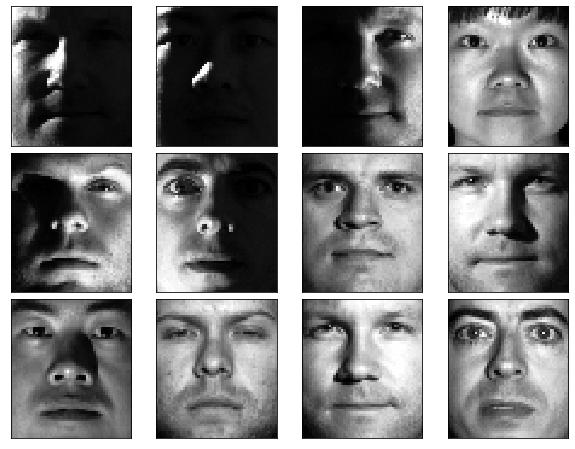

In [48]:
visualise_images(X, 12, 4)

Now define the function to add noise

In [49]:
import random
def mask_noise(X, dims = 20):
    num_images, row, col = X.shape
    
    masks = np.zeros(X.shape)
    for i in range(num_images):
        x_coord = random.randint(0, col - 1)
        y_coord = random.randint(0, row - 1)
        if x_coord + 19 <= col - 1:
            x_range = x_coord + 19
        else: 
            x_range = x_coord
            x_coord = x_coord - 19
        if y_coord + 19 <= row - 1:
            y_range = y_coord + 19
        else: 
            y_range = y_coord
            y_coord = y_coord - 19
        masks[i, y_coord:y_range, x_coord:x_range] = 1
    masks = masks.astype(bool)
    return masks

Now visualize the images with the added noise.

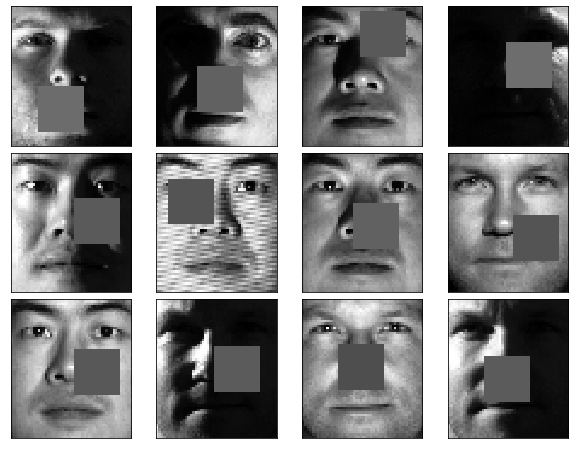

In [50]:
noise_mask = mask_noise(X)
X[noise_mask] = 0
visualise_images(X, 12, 4)

Now recover the original images using robust pca from tensorly.

In [53]:
#!pip install tensorly
from tensorly.decomposition import robust_pca

In [54]:
low_rank_part, sparse_part = robust_pca(X, mask=~noise_mask, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

Copied the code to visualize the robust pca reconstruction process

In [55]:
def visualise_rpca(X, low_rank_part, sparse_part, n_images=10):
    """A little helper function to visualise the result of tensor RPCA
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]

    fig = plt.figure(figsize=(10, 2*n_images))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        cmap = plt.cm.Greys_r

        ax = fig.add_subplot(n_images, 4, 4*i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Original')

        ax = fig.add_subplot(n_images, 4, 4*i + 2, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Low-rank')

        ax = fig.add_subplot(n_images, 4, 4*i + 3, xticks=[], yticks=[])
        ax.imshow(sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Sparse')

        ax = fig.add_subplot(n_images, 4, 4*i + 4, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e]+sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Reconstruction')


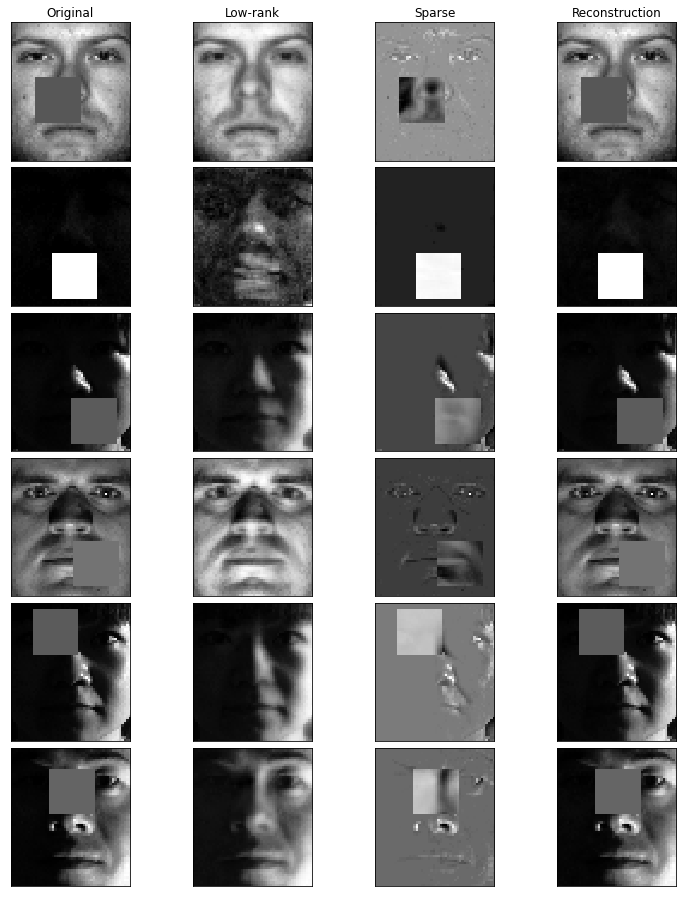

In [56]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=6)

### Sorry it was late, I caught significant traffic on my way home and had a late start. Very cool assignment!